# **EECS 442 PS8: Panoramic Stitching**

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

Yehan He, mperform



# Brief Overview

In this problem set, you will implement panoramic stitching. Given two input images, we will "stitch" them together to create a simple panorama. To construct the image panorama, we will use concepts learned in class such as keypoint detection, local invariant descriptors, RANSAC, and perspective warping.

8.1 You are given a npy file consisting the original points and target points. You want to find the homography transformation that map the original points to the destination points. Please generate 3 plots: original points, destination points, and mapped points
 for visualization

8.2 The panoramic stitching algorithm consists of four main steps which we ask you to implement in individual functions:

1. Detect keypoints and extract local invariant descriptors (we will be using ORB) from two input images.

2. Match the descriptors between the two images.

3. Apply RANSAC to estimate a homography matrix between the extracted features.

4. Apply a perspective transformation using the homography matrix to merge image into a panorama.

Functions to implement (refer to function comments for more detail):

1. $\texttt{fit_homography}$ (2 points)

2. $\texttt{apply_homography}$ (2 points)

1. $\texttt{get_orb_features}$ (2 points)

2. $\texttt{match_keypoints}$ (2 points)

3. $\texttt{transform_ransac}$ (2 points)

4. $\texttt{panoramic_stitching}$ (2 points)

Retreive the npy file online and convert to np array

In [ ]:
%%capture
!wget -O file1.npy 'https://docs.google.com/uc?export=download&id=1SAZHI9hzfo3B6WonI_Lmd20INcA35t0e'

(1205, 4)


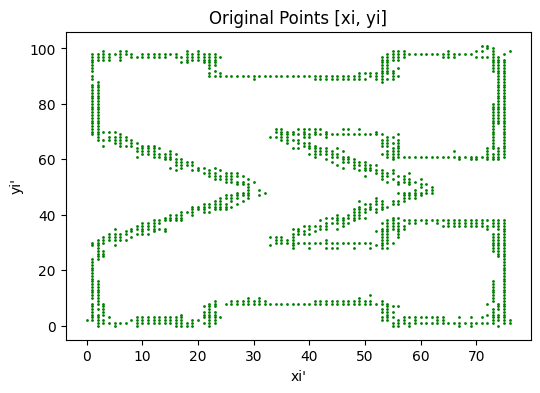

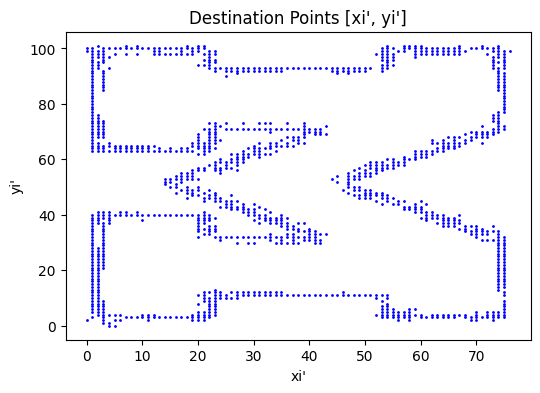

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
data = np.load("file1.npy")
print(data.shape)

plt.figure(figsize=(6, 4))
plt.scatter(data[:, 0], data[:, 1], s=1, c='green')
plt.title('Original Points [xi, yi]')
plt.xlabel("xi'")
plt.ylabel("yi'")
plt.show()

# Plot for [xi', yi']
plt.figure(figsize=(6, 4))
plt.scatter(data[:, 2], data[:, 3], s=1, c='blue')
plt.title('Destination Points [xi\', yi\']')
plt.xlabel("xi'")
plt.ylabel("yi'")
plt.show()


#8.1 Homography estimation


Your first task is to implement a function fit_homography(pts1, pts2) that computes the homography matrix from a set of point correspondences.

This should fit a homography mapping between the two given points. You will use it to map the original points to the destination points.



In [ ]:
def fit_homography(pts1, pts2):
    '''
    Given a set of N correspondences of the form [x,y], [x',y'],
    fit a homography that maps [x',y',1] to [x,y,1].

    Input - pts1, pts2: (N, 2) matrices representing N corresponding points [x, y] and [x', y']
    Output - H: a (3,3) homography matrix that (if the correspondences can be
            described by a homography) satisfies [x,y,1] === H [x',y',1]

    Use either nonlinear least squares or direct linear transform
    to find a homography that estimates the transformation mapping from pts2
    to pts1.
    e.g. If u = pts1[i] and v = pts2[i], then u = H * v in homogeneous coordinates

    Hint if using nonlinear least square:
      The objective function to optimize here is:
      \sum_i ||pts1[i] - cart(H*homog(pts2[i]))||^2 where homog(x) converts x into
      homogeneous coordinates and cart(x) converts x to cartesian coordinates.
      You can use scipy.optimize.least_squares for this.

    Hint if using direct linear transform:
      The solution is given by the right-singular vector with the smallest singular value in the singular vector decomposition.
      You can use np.linalg.svd for this.

    Input:
      pts1, pts2: (N, 2) matrix
    Return:
      H: the resulting homography matrix (3 x 3)

    '''
    #############################################################################
    #                                   TODO                                    #
    #############################################################################
    #we want the points to be homogeneous
    def homogeneous(x):
      if x.ndim == 1:
        x = x.reshape(-1, 2)
      return np.hstack([x, np.ones((x.shape[0], 1))])

    #Error checking
    if pts1.ndim == 1 or pts2.ndim == 1:
        raise ValueError("pts1 and pts2 must be 2-dimensional arrays with shape (N, 2)")
    if pts1.shape[1] != 2 or pts2.shape[1] != 2:
        raise ValueError("pts1 and pts2 must have shape (N, 2)")

    #convert to coordinates
    pts1_h = homogeneous(pts1)
    pts2_h = homogeneous(pts2)

    #construct our matrix
    A = []
    for i in range(len(pts1)):
      x, y = pts1[i, 0], pts1[i, 1]
      u, v = pts2[i,0], pts2[i, 1]
      A.append([-u, -v, -1, 0, 0, 0, x * u, x * v, x])
      A.append([0,0,0,-u,-v,-1,y * u, y * v, y])

    A = np.array(A)

    # SVD
    U, S, Vh = np.linalg.svd(A)

    #last row of Vh
    H = Vh[-1].reshape(3,3)

    #normalize matrix
    H = H / H[2,2]
    return H

    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################



Visualize the original points, target points and points after applying a homography transform in three separate figures: original points, destination points, and mapped points


plt.scatter may be useful here


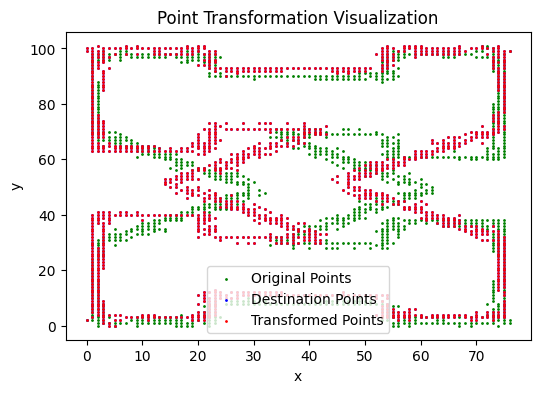

array([[ 7.60000000e+01,  9.90000000e+01],
       [ 7.50000000e+01,  9.90000000e+01],
       [ 7.50000000e+01,  9.80000000e+01],
       ...,
       [-4.39115411e-12,  1.00000000e+02],
       [-4.39115411e-12,  9.90000000e+01],
       [-3.49587026e-12,  2.00000000e+00]])

In [ ]:
def apply_homography(data):
    #############################################################################
    #                                   TODO                                    #
    #############################################################################
    '''
    Given loaded file1.npy, which is data, apply the transformation. data is in the
    form [x1,y1,x2,y2]

    Steps:
    1. Find the homography matrix
    2. Transform the data to homogeneous coordinates, then apply the transformation
    3. Transform the data back to Euclidean coordinates
    '''
    # init our points

    pt1 = data[:, :2] # these are the original points
    pt2 = data[:, 2:] # Desired destination points

    # compute the homography matrix
    H = fit_homography(pt1, pt2)

    # transform the data to homogeneous coordinates and apply the transformation
    pt1_h = np.hstack([pt1, np.ones((pt1.shape[0], 1))])
    transformed = (H @ pt1_h.T).T #apply homography to data

    # transform back to euclidean coordinate plane
    transformed = transformed[:, :2] / transformed[:, [2]]

    # visualization we can use this to visualize our data
    plt.figure(figsize=(6, 4))
    plt.scatter(pt1[:, 0], pt1[:, 1], s=1, c='green', label='Original Points')
    plt.scatter(pt2[:, 0], pt2[:, 1], s=1, c='blue', label='Destination Points')
    plt.scatter(transformed[:, 0], transformed[:, 1], s=1, c='red', label='Transformed Points')
    plt.title('Point Transformation Visualization')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

    return transformed


    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################


apply_homography(data)


# 8.2 Panoramic stitching

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [ ]:
%matplotlib inline
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
%%capture
! wget -O img1.jpg "https://drive.google.com/uc?export=download&id=1omMydL6ADxq_vW5gl_1EFhdzT9kaMhUt"
! wget -O img2.jpg "https://drive.google.com/uc?export=download&id=12lxB1ArAlwGn97XgBgt-SFyjE7udMGvf"

# Visualize Input Images

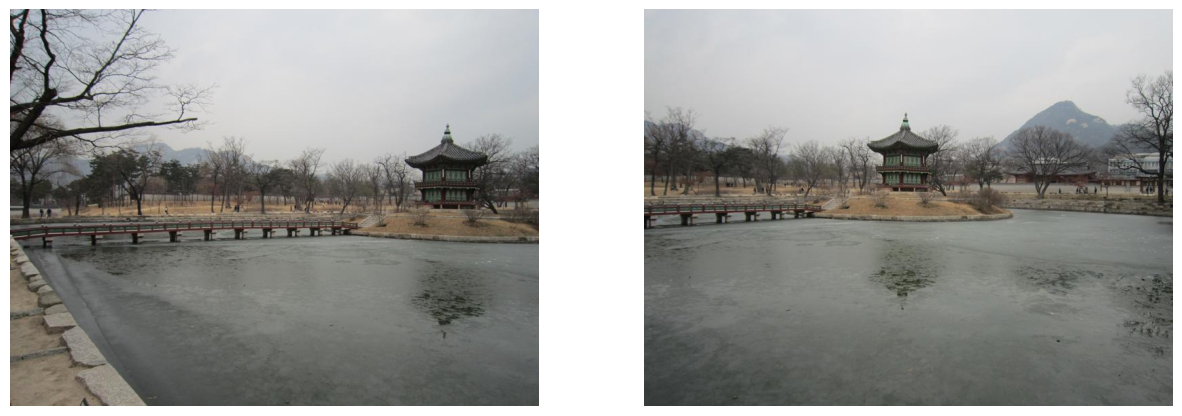

In [ ]:
img1 = plt.imread('img1.jpg')
img2 = plt.imread('img2.jpg')

def plot_imgs(img1, img2):
  fig, ax = plt.subplots(1, 2, figsize=(15, 20))
  for a in ax:
    a.set_axis_off()
  ax[0].imshow(img1)
  ax[1].imshow(img2)

plot_imgs(img1, img2)

# (a) Feature Extraction

## (i) Compute ORB Features

In [ ]:
def get_orb_features(img):
  '''
    Compute ORB features using cv2 library functions.
    Use default parameters when computing the keypoints.
    Hint: you will need cv2.ORB_create() and some related functions
    Input:
      img: cv2 image
    Returns:
      keypoints: a list of cv2 keypoints
      descriptors: a list of ORB descriptors
  '''
  #############################################################################
  #                                   TODO                                    #
  #############################################################################
  # create an orb object first
  orb = cv2.ORB_create()
  keypoints, descriptors = orb.detectAndCompute(img, None)
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################
  return keypoints, descriptors


## (ii) Match Keypoints

In [ ]:
def match_keypoints(desc_1, desc_2, ratio=0.75):
  '''
    Compute matches between feature descriptors of two images using
    Lowe's ratio test. You may use cv2 library functions.
    Hint: you may need to use cv2.DescriptorMatcher_create or cv2.BFMatcher
    and some related functions
    Input:
      desc_1, desc_2: list of feature descriptors
    Return:
      matches: list of feature matches
  '''
  #############################################################################
  #                                   TODO                                    #
  #############################################################################
  # using BFMatcher to create our BF
  bf = cv2.BFMatcher(cv2.NORM_HAMMING)
  # get the knn matches
  knn_matches = bf.knnMatch(desc_1, desc_2, k=2)
  # Apply Lowe's ratio test
  good_matches = []
  for m, n in knn_matches:
    if m.distance < ratio * n.distance:
      good_matches.append(m)

  matches = good_matches
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################

  return matches

keypoints for img1 and img2


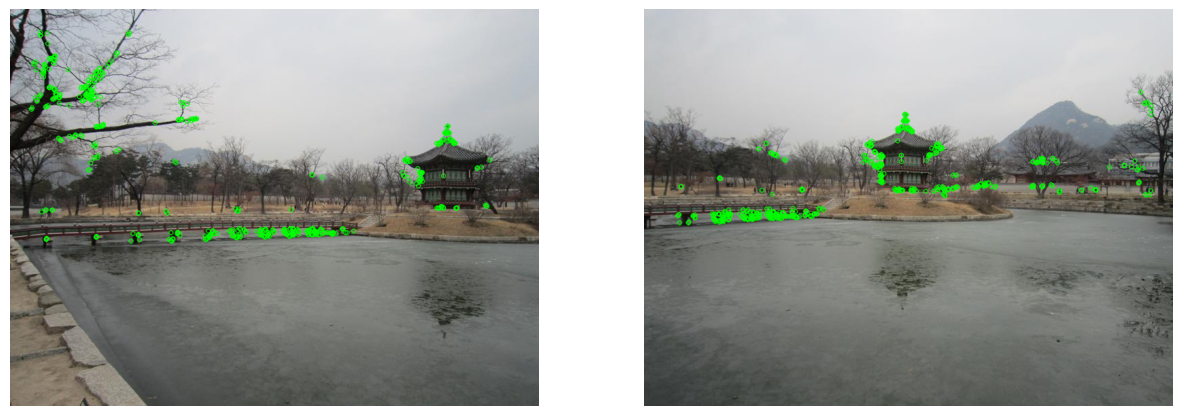

In [ ]:
kp_1, desc_1 = get_orb_features(img1)
kp_2, desc_2 = get_orb_features(img2)

kp_img1 = cv2.drawKeypoints(img1, kp_1, None, color=(0,255,0), flags=0)
kp_img2 = cv2.drawKeypoints(img2, kp_2, None, color=(0,255,0), flags=0)

print('keypoints for img1 and img2')
plot_imgs(kp_img1, kp_img2)

orb feature matches


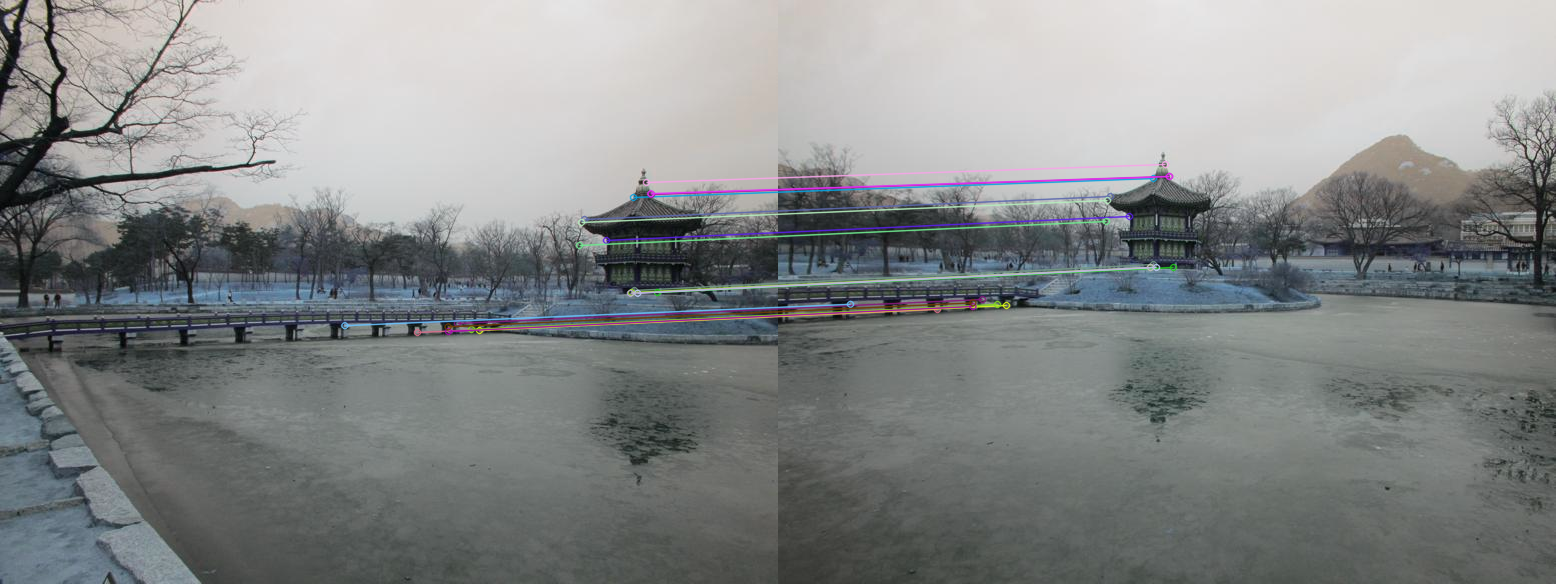

In [ ]:
matches = match_keypoints(desc_1, desc_2)
match_plot = cv2.drawMatches(img1, kp_1, img2, kp_2, matches[:20], None, flags=2)
print("orb feature matches")
cv2_imshow(match_plot)

# (b) Implement RANSAC

In [ ]:
def transform_ransac(x1, x2, verbose=False):
  '''
    Implements RANSAC to estimate homography matrix.
    Hint: Follow the RANSAC steps outlined in the lecture slides.
    Input:
      pts_1, pts_1: (N, 2) matrices
    Return:
      best_model: homography matrix with most inliers
  '''
  #############################################################################
  #                                   TODO                                    #
  #############################################################################
  iterations = 2000
  threshold = 3.0

  best_model = None
  max_inliers = 0

  for _ in range(iterations):
      # Randomly sample 4 points
      indices = np.random.choice(len(x1), 4, replace=False)
      sampled_x1 = np.squeeze(x1[indices])
      sampled_x2 = np.squeeze(x2[indices])

      # Estimate homography
      H = fit_homography(sampled_x1, sampled_x2)

      col_1 = np.ones((len(x2), 1))
      x2_homog = np.concatenate((x2, col_1), axis=1)
      x2_transformed = np.dot(H, x2_homog.T).T
      x2_transformed = x2_transformed / x2_transformed[:, 2][:, np.newaxis]

      errors = np.linalg.norm(x1 - x2_transformed[:, :2], axis=1)
      inliers = np.sum(errors < threshold) # find all the errors below threshold
      # Update best model if current model has more inliers
      if inliers > max_inliers:
          best_model = H
          max_inliers = inliers
  #get indices for the inlier and update best_model for returning
  inlier_index = np.where(errors < threshold)[0]
  best_model = fit_homography(x1[inlier_index], x2[inlier_index])
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################
  # return best_inliers, best_model
  return best_model

# (c) Panoramic Stitching

In [ ]:
def panoramic_stitching(img1, img2):
  '''
    Given a pair of overlapping images, generate a panoramic image.
    Hint: use the functions that you've written in the previous parts.
    Input:
      img1, img2: images
    Return:
      final_img: image of panorama
  '''
  #############################################################################
  #                                   TODO                                    #
  # 1. detect keypoints and extract orb feature descriptors                   #
  # 2. match features between two images                                      #
  # 3. compute homography matrix H transforming points from pts_2 to pts_1.   #
  # Note the order here (not pts_1 to pts_2)!                                 #
  #############################################################################
  keypoint1, descriptor1 = get_orb_features(img1)
  keypoint2, descriptor2 = get_orb_features(img2)

  # Match features between two images
  matches = match_keypoints(descriptor1, descriptor2)
  matches.sort(key=lambda x: x.distance)
  # Extract matching keypoints for the homography from img2 to img1
  pts_img1 = np.float32([keypoint1[m.queryIdx].pt for m in matches])
  pts_img2 = np.float32([keypoint2[m.trainIdx].pt for m in matches])

  # Compute homography matrix H
  H = transform_ransac(pts_img1, pts_img2)
  # apply perspective wrap to stitch images together
  final_img = cv2.warpPerspective(img2, H, (img2.shape[1] + img1.shape[1], img2.shape[0] * 2))
  final_img[0:img1.shape[0], 0:img1.shape[1]] = img1
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################

  return final_img


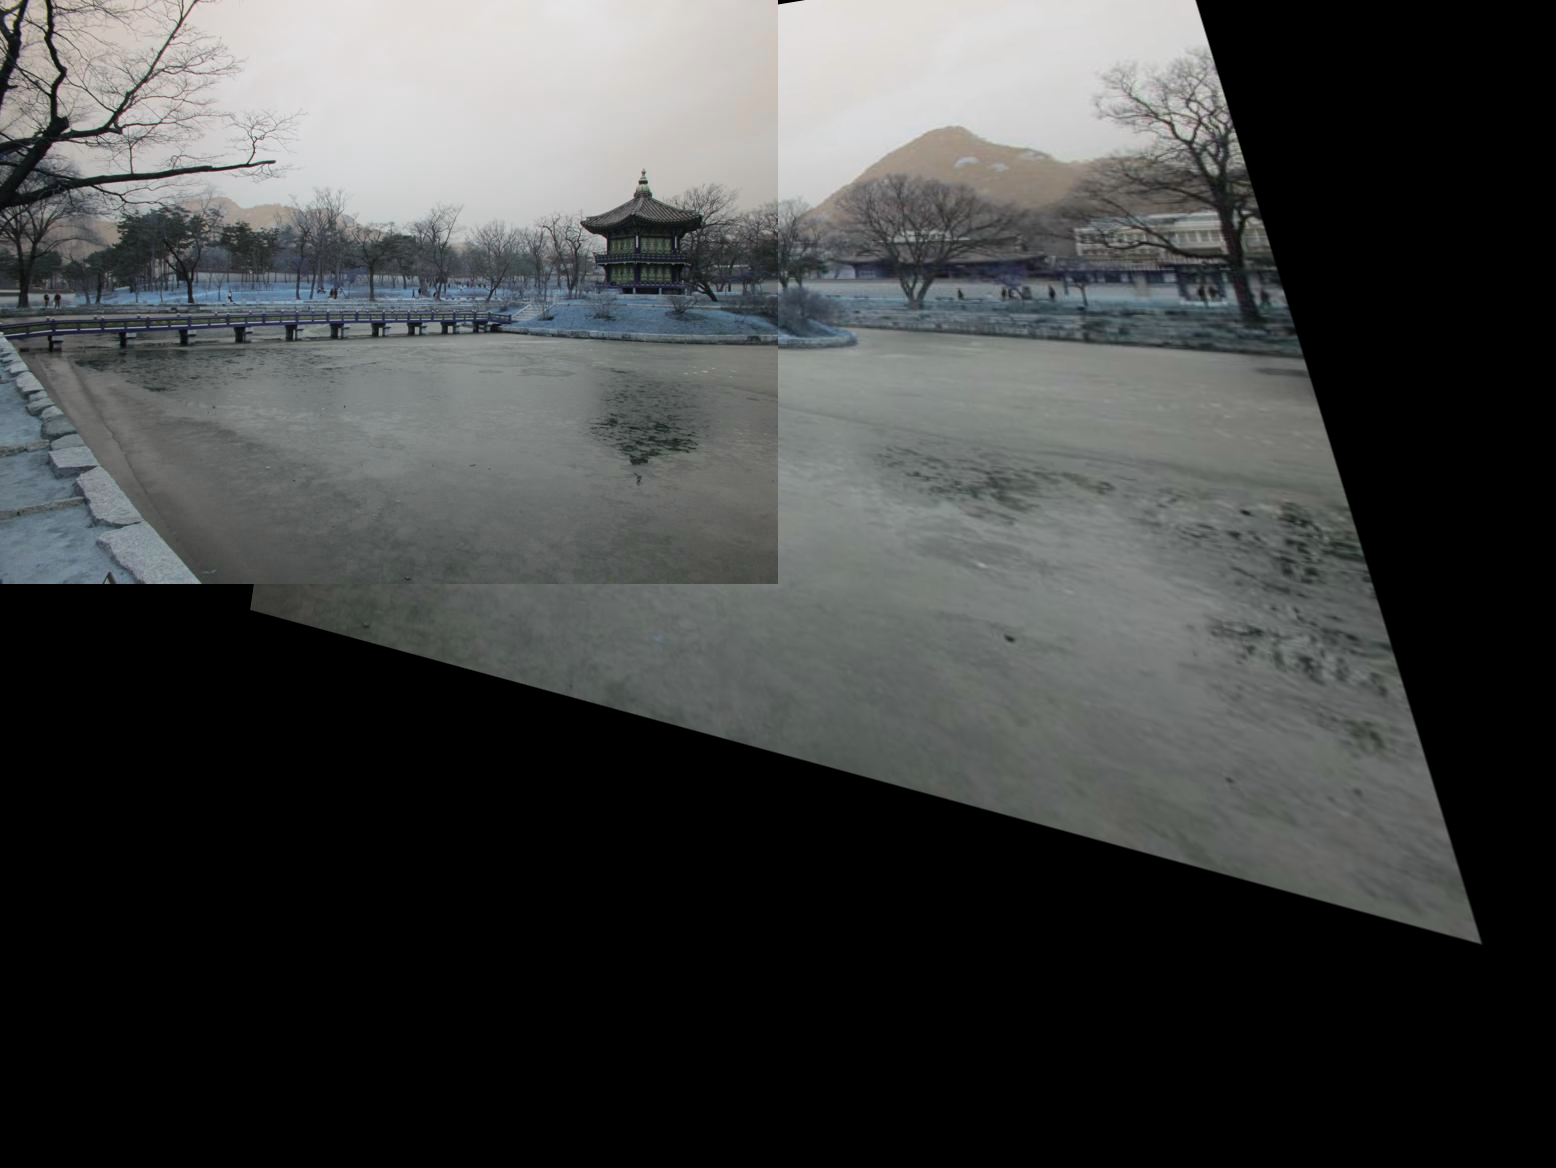

In [ ]:
result = panoramic_stitching(img1, img2)
cv2_imshow(result)

# Convert to PDF
Before converting to pdf, please get rid of the **funuction points declaration text** starts with "Functions to implement (refer to function comments for more detail)" of the brief overview section at the top. That part of text requires specific latex libaraies for conversion and may affect your pdf conversion process.

This may be important if you have failed converting to pdf.


In [ ]:
# generate pdf
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!
import os
notebookpath = '' # Ex: notebookpath = '/content/drive/My Drive/Colab Notebooks/EECS 442 Fall 2023 - PS8.ipynb'
drive_mount_point = '/content/drive/'
from google.colab import drive
drive.mount(drive_mount_point)
file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("pip install pypandoc")
get_ipython().system("apt-get install texlive texlive-xetex texlive-latex-extra pandoc")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
from google.colab import files
files.download(notebookpath.split('.')[0]+'.pdf')

MessageError: ignored